# Find the best neighborhood in Madrid to open a Restaurant

### 1. Introduction
  


Madrid is the capital and the most populated city in Spain. The city has almost 3.3 million inhabitants and a metropolitan area population of approximately 6.5 million. It concentrates activities directly related to power and to knowledge and technological innovation. It is one of the largest financial centers in Europe and the largest in Spain.

  * **Bussines Poblem**
  
Madrid is administratively divided into 21 districts, which in turn are subdivided into 131 neighborhoods. 

Are there differences from one district to another? How are businesses distributed in each of your districts? Where would it be more prosperous to open a new restaurant?

In this analysis we will try to find an optimal location for a restaurant in Madrid taking into account the competitors and which group of people with income will be attracted according to the population of the neighborhood. To do this we will use an unsupervised automatic learning algorithm (K-Means) and will take into account demographic data, per capita income by district and housing prices.


### 2. Data acquisition

Based on the definition of our problem. The necessary data sources have been obtained from:

- **Foursquare API**: Collection of restaurant related data (location, distribution, type of food)

- **National Institute of Statistics (INE)**: Official site for downloading demographic data, per capita income and housing prices.

- **Madrid City Council open data portal**: Official site for downloading data related to Madrid.

### 3. Methodology


#### Importing the necessary libraries

In [50]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

import requests # library to handle requests

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


#### Reading datasets

In [51]:
# Boroughs and Neighborhoods from Madrid
df = pd.read_csv('barrios_municipio_madrid.csv',sep= ';', encoding='Latin 1')
df.head()

,barrio_codigo,barrio_nombre,distrito_codigo,distrito_nombre,municipio_codigo,municipio_nombre,superficie_km2,densidad_por_km2
0,796011,Palacio,79601,Centro,796,Madrid,1.46,15323.29
1,796012,Embajadores,79601,Centro,796,Madrid,1.03,43345.63
2,796013,Cortes,79601,Centro,796,Madrid,0.59,17850.85
3,796014,Justicia,79601,Centro,796,Madrid,0.75,21866.67
4,796015,Universidad,79601,Centro,796,Madrid,0.93,33051.61


In [52]:
df.columns

Index(['barrio_codigo', 'barrio_nombre', 'distrito_codigo', 'distrito_nombre',
       'municipio_codigo', 'municipio_nombre', 'superficie_km2',
       'densidad_por_km2'],
      dtype='object')

In [53]:
df.shape

(128, 8)

In [54]:
# Extracting the necessary columns 
dfm=df.groupby(['distrito_codigo','distrito_nombre']).agg(','.join)
dfm.reset_index(inplace=True)
dfm.drop(['municipio_nombre'], axis=1, inplace=True)
dfm

,distrito_codigo,distrito_nombre,barrio_nombre
0,79601,Centro,"Palacio, Embajadores, Co..."
1,79602,Arganzuela,"Imperial, Las Acacias, L..."
2,79603,Retiro,"Pacífico, Adelfas, Estre..."
3,79604,Salamanca,"Recoletos, Goya, Fuente ..."
4,79605,Chamartín,"El Viso, Prosperidad, Ci..."
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ..."
6,79607,Chamberí,"Gaztambide, Arapiles, Tr..."
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ..."
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ..."
9,79610,Latina,"Los Cármenes, Puerta del Angel,..."


In [55]:
dfm.shape

(21, 3)

In [56]:
# Population by borough
df2 = pd.read_csv('poblacion_distritos.csv',sep= ';')
df2.head()

,Distrito,Superficie (Ha),Densidad (hab./Ha),Población a 1-1-2020
0,Centro,"522,82","268,68",140.473
1,Arganzuela,"646,22",241,155.660
2,Retiro,"546,62",220,120.406
3,Salamanca,"539,24",274,147.854
4,Chamartín,"917,55",161,147.551


In [57]:
# Per capita income  and housing prices by borough
pv=pd.read_excel('precio_vivienda.xls', sheet_name=0)
pv

,Distrito,Nov_20,Oct_20,Sep_20,Ago_20,Jul_20,Jun_20,May_20,Abr_20,Mar_20,...,Sep_19,Ago_19,Jul_19,Jun_19,May_19,Abr_19,Mar_19,Feb_19,Ene_19,Renta_INE
0,Centro,4878,4909,4934,4963,4981,5061,5075,5062,5026,...,4994,4993,5044,5031,4991,5034,5069,5033,4987,16147
1,Arganzuela,3917,3908,3915,3912,3910,3948,3962,3903,3878,...,4059,4073,4096,4085,4080,4095,4071,4042,4017,17306
2,Retiro,3917,3908,3915,3912,4513,4564,4586,4560,4555,...,4572,4575,4598,4660,4669,4637,4631,4614,4529,21504
3,Salamanca,4520,5808,5826,5833,5903,5986,3962,3903,4555,...,5788,5791,5860,5868,5848,5850,5818,5829,5752,24433
4,Chamartín,5018,5040,5056,5068,5109,5180,5179,5143,5118,...,4980,4931,4941,4934,5051,5102,5174,5196,5187,25969
5,Tetuán,5018,5040,5056,3669,3682,3696,3679,3714,3725,...,3716,3719,3702,3719,3722,3731,3725,3693,3644,14970
6,Chamberí,5288,5334,5374,5329,5337,5419,5432,5426,5386,...,5331,5347,5309,5271,5287,5276,5249,5253,5285,22499
7,Fuencarral-El Pardo,3917,3908,3915,3912,4513,5986,3573,3570,3530,...,3480,3447,3436,3369,3402,3418,3379,3364,3374,18573
8,Moncloa-Aravaca,3893,3877,3913,3905,3910,3913,3898,3932,3939,...,3896,3910,3931,3928,3950,3905,3892,3875,3854,22152
9,Latina,2246,2246,2254,2269,2310,2330,2330,2364,2341,...,2292,2293,2276,2292,2290,2291,2280,2305,2303,12232


In [58]:
pv['AvgHousingPrice']=pv.mean(axis=1)
pv

,Distrito,Nov_20,Oct_20,Sep_20,Ago_20,Jul_20,Jun_20,May_20,Abr_20,Mar_20,...,Ago_19,Jul_19,Jun_19,May_19,Abr_19,Mar_19,Feb_19,Ene_19,Renta_INE,AvgHousingPrice
0,Centro,4878,4909,4934,4963,4981,5061,5075,5062,5026,...,4993,5044,5031,4991,5034,5069,5033,4987,16147,5479.500000
1,Arganzuela,3917,3908,3915,3912,3910,3948,3962,3903,3878,...,4073,4096,4085,4080,4095,4071,4042,4017,17306,4547.750000
2,Retiro,3917,3908,3915,3912,4513,4564,4586,4560,4555,...,4575,4598,4660,4669,4637,4631,4614,4529,21504,5178.416667
3,Salamanca,4520,5808,5826,5833,5903,5986,3962,3903,4555,...,5791,5860,5868,5848,5850,5818,5829,5752,24433,6352.916667
4,Chamartín,5018,5040,5056,5068,5109,5180,5179,5143,5118,...,4931,4941,4934,5051,5102,5174,5196,5187,25969,5944.666667
5,Tetuán,5018,5040,5056,3669,3682,3696,3679,3714,3725,...,3719,3702,3719,3722,3731,3725,3693,3644,14970,4333.708333
6,Chamberí,5288,5334,5374,5329,5337,5419,5432,5426,5386,...,5347,5309,5271,5287,5276,5249,5253,5285,22499,6040.750000
7,Fuencarral-El Pardo,3917,3908,3915,3912,4513,5986,3573,3570,3530,...,3447,3436,3369,3402,3418,3379,3364,3374,18573,4322.333333
8,Moncloa-Aravaca,3893,3877,3913,3905,3910,3913,3898,3932,3939,...,3910,3931,3928,3950,3905,3892,3875,3854,22152,4676.958333
9,Latina,2246,2246,2254,2269,2310,2330,2330,2364,2341,...,2293,2276,2292,2290,2291,2280,2305,2303,12232,2711.583333


In [59]:
pv.columns

Index(['Distrito', 'Nov_20', 'Oct_20', 'Sep_20', 'Ago_20', 'Jul_20', 'Jun_20',
       'May_20', 'Abr_20', 'Mar_20', 'Feb_20', 'Ene_20', 'Unnamed: 12',
       'Dic_19', 'Nov_19', 'Oct_19', 'Sep_19', 'Ago_19', 'Jul_19', 'Jun_19',
       'May_19', 'Abr_19', 'Mar_19', 'Feb_19', 'Ene_19', 'Renta_INE',
       'AvgHousingPrice'],
      dtype='object')

In [60]:
renta=pv[['Distrito','Renta_INE','AvgHousingPrice']]
renta

,Distrito,Renta_INE,AvgHousingPrice
0,Centro,16147,5479.500000
1,Arganzuela,17306,4547.750000
2,Retiro,21504,5178.416667
3,Salamanca,24433,6352.916667
4,Chamartín,25969,5944.666667
5,Tetuán,14970,4333.708333
6,Chamberí,22499,6040.750000
7,Fuencarral-El Pardo,18573,4322.333333
8,Moncloa-Aravaca,22152,4676.958333
9,Latina,12232,2711.583333


In [61]:
# Merging in a single dataset
md = dfm.join(df2['Población a 1-1-2020'])
md

,distrito_codigo,distrito_nombre,barrio_nombre,Población a 1-1-2020
0,79601,Centro,"Palacio, Embajadores, Co...",140.473
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139


In [62]:
md2 = md.join(renta)
md2.drop('Distrito', axis=1, inplace=True)
md2

,distrito_codigo,distrito_nombre,barrio_nombre,Población a 1-1-2020,Renta_INE,AvgHousingPrice
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333


In [63]:
md2.shape

(21, 6)

In [64]:
# Renaming the columns
md2.rename(columns={'distrito_codigo': 'Postcode', 'distrito_nombre':'Borough','barrio_nombre':'Neighborhood','Población a 1-1-2020':'Population', 'Renta_INE':'RentaINE'}, inplace=True)
md2

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333


In [65]:
md2.describe()

,Postcode,Population,RentaINE,AvgHousingPrice
count,21.000000,21.000000,21.000000,21.000000
mean,79611.000000,158.796667,16078.428571,3882.521825
std,6.204837,57.538604,5046.096229,1364.257435
min,79601.000000,50.010000,9395.000000,2049.583333
25%,79606.000000,121.683000,11925.000000,2702.416667
50%,79611.000000,147.854000,15408.000000,3770.916667
75%,79616.000000,193.264000,18573.000000,4676.958333
max,79621.000000,260.196000,25969.000000,6352.916667


#### Graphing the percentage of population for each district

In [66]:
data = md2.groupby('Borough')['Population'].sum()

In [67]:
data_per = data.groupby('Borough').agg(percentage =('Population', lambda p: p.sum() / data.sum() * 100)).round(2)

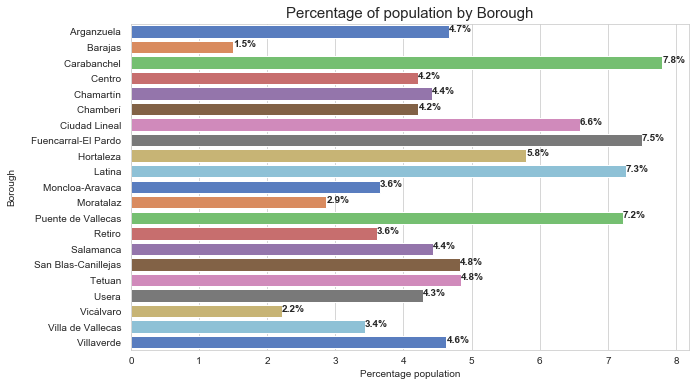

In [68]:

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per.index, data=data_per, ci=None, palette="muted",orient='h' )
ax.set_title("Percentage of population by Borough", fontsize=15)
ax.set_xlabel ("Percentage population")
ax.set_ylabel ("Borough")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
bar.savefig("Seaborn_Bar_Vertical.png");

#### Graphing the Renta for each district

In [69]:
data2 = md2.groupby('Borough')['RentaINE'].sum()
data_per2 = data2.groupby('Borough').agg(percentage =('RentaINE', lambda p: p.sum() / data2.sum() * 100)).round(2)

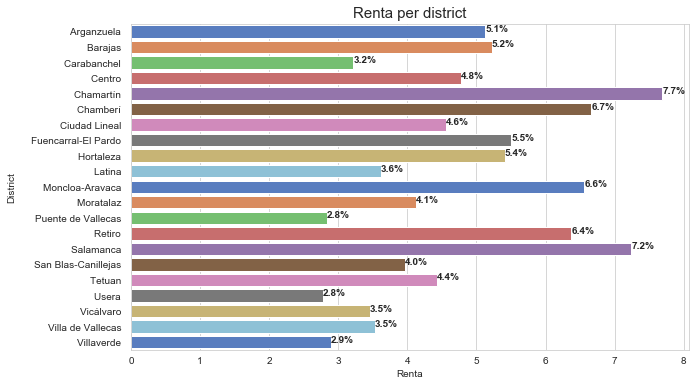

In [70]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per2.index, data=data_per2, ci=None, palette="muted",orient='h' )
ax.set_title("Renta per district", fontsize=15)
ax.set_xlabel ("Renta")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

#### Getting latitude and longitude data for each borough in a new dataset

In [71]:
# Creating a new dataframe
dist_name= md2['Borough'].tolist()
columns=['Borough','Latitude','Longitude']
columns

['Borough', 'Latitude', 'Longitude']

In [72]:
# Latitude and Longitude by Borough
dist_name= md2['Borough'].tolist()
columns=['Borough','Latitude','Longitude']
lat_lng=pd.DataFrame(columns=columns)
for borough in dist_name:
    locator=Nominatim(user_agent= 'init')
    location=locator.geocode('{}, Madrid, Spain'.format(borough))
    lat=location.latitude
    lng=location.longitude
    print('Borough = {}, Latitude = {}, Longitude = {}'.format(borough,location.latitude, location.longitude))
    lat_lng=lat_lng.append({'Borough': borough, 'Latitude': lat,'Longitude':lng},ignore_index=True)
lat_lng    

Borough =     Centro , Latitude = 40.417652700000005, Longitude = -3.7079137662915533
Borough =     Arganzuela , Latitude = 40.39806845, Longitude = -3.6937339526567428
Borough =     Retiro , Latitude = 40.4111495, Longitude = -3.6760566
Borough =     Salamanca , Latitude = 40.4270451, Longitude = -3.6806024
Borough =     Chamartín , Latitude = 40.4589872, Longitude = -3.6761288
Borough =     Tetuan , Latitude = 40.4605781, Longitude = -3.6982806
Borough =     Chamberí , Latitude = 40.43624735, Longitude = -3.7038303534513837
Borough =     Fuencarral-El Pardo , Latitude = 40.55634555, Longitude = -3.7785905137518054
Borough =     Moncloa-Aravaca , Latitude = 40.43949485, Longitude = -3.7442035396547055
Borough =     Latina , Latitude = 40.4035317, Longitude = -3.736152
Borough =     Carabanchel , Latitude = 40.3742112, Longitude = -3.744676
Borough =     Usera , Latitude = 40.383894, Longitude = -3.7064459
Borough =     Puente de Vallecas , Latitude = 40.3835532, Longitude = -3.6545354

,Borough,Latitude,Longitude
0,Centro,40.417653,-3.707914
1,Arganzuela,40.398068,-3.693734
2,Retiro,40.411150,-3.676057
3,Salamanca,40.427045,-3.680602
4,Chamartín,40.458987,-3.676129
5,Tetuan,40.460578,-3.698281
6,Chamberí,40.436247,-3.703830
7,Fuencarral-El Pardo,40.556346,-3.778591
8,Moncloa-Aravaca,40.439495,-3.744204
9,Latina,40.403532,-3.736152


In [73]:
lat_lng.shape

(21, 3)

In [74]:
# Merging geographic variables with the md2 dataframe
madrid_data=pd.merge(md2,lat_lng, on='Borough')
madrid_data

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000,40.417653,-3.707914
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000,40.398068,-3.693734
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667,40.411150,-3.676057
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667,40.427045,-3.680602
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667,40.458987,-3.676129
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333,40.460578,-3.698281
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000,40.436247,-3.703830
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333,40.556346,-3.778591
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333,40.439495,-3.744204
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333,40.403532,-3.736152


##### Plotting all Borough

In [75]:
# Latitude and Longitude of Madrid
mad=locator.geocode('Madrid, Spain')
print((mad.latitude, mad.longitude))

(40.4167047, -3.7035825)


In [76]:
# Reading file geojson
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data'
madrid_geo = f'{url}/madrid-districts.geojson'

# Creating map
map_madrid = folium.Map(location=[40.4167047, -3.7035825], zoom_start=10)
map_madrid.choropleth(geo_data=madrid_geo,
                      name='choropleth',
                      data=madrid_data,
                      columns=['Borough','Population'],
                      key_on='feature.properties.name',
                      fill_color='YlOrRd',
                      fill_opacity=0.7,
                      line_opacity=0.2)

# Adding markers to map
for lat, lng, borough, neighborhood in zip(madrid_data['Latitude'], madrid_data['Longitude'], madrid_data['Borough'], madrid_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

#### Using the Foursquare API to explore the bussines in each borough.

In [77]:
CLIENT_ID = 'XXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 1000

In [78]:

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [79]:
madrid_venues = getNearbyVenues(names=madrid_data['Neighborhood'],
                                   latitudes=madrid_data['Latitude'],
                                   longitudes=madrid_data['Longitude']
                                  )

        Palacio,        Embajadores,        Cortes,        Justicia,        Universidad,        Sol
        Imperial,        Las Acacias,        La Chopera,        Legazpi,        Delicias,        Palos de Moguer,        Atocha
        Pacífico,        Adelfas,        Estrella,        Ibiza,        Jerónimos,        Niño Jesús
        Recoletos,        Goya,        Fuente del Berro,        Guindalera,        Lista,        Castellana
        El Viso,        Prosperidad,        Ciudad Jardín,        Hispanoamérica,        Nueva España,        Castilla
        Bellas Vistas,        Cuatro Caminos,        Castillejos,        Almenara,        Valdeacederas,        Berruguete
        Gaztambide,        Arapiles,        Trafalgar,        Almagro,        Ríos Rosas,        Vallehermoso
        El Pardo,        Fuentelarreina,        Peña Grande,        El Pilar,        La Paz,        Valverde,        Mirasierra,        El Goloso
        Casa de Campo,        Argüelles,        Ciudad Universita

In [80]:
madrid_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Palacio, Embajadores, Co...",40.417653,-3.707914,Plaza de Isabel II,40.418114,-3.709397,Plaza
1,"Palacio, Embajadores, Co...",40.417653,-3.707914,Puerta del Sol,40.417034,-3.705251,Plaza
2,"Palacio, Embajadores, Co...",40.417653,-3.707914,Plaza Mayor,40.415527,-3.707506,Plaza
3,"Palacio, Embajadores, Co...",40.417653,-3.707914,Amorino,40.416065,-3.708383,Ice Cream Shop
4,"Palacio, Embajadores, Co...",40.417653,-3.707914,Cerveceria Erte,40.419241,-3.707470,Bar
...,...,...,...,...,...,...,...
1120,"Alameda de Osuna, Aeropuerto, ...",40.473318,-3.579845,Madrid Duty Free T2,40.470049,-3.569345,Duty-free Shop
1121,"Alameda de Osuna, Aeropuerto, ...",40.473318,-3.579845,Flight Air Europa UX1171 MAD–BRU,40.473210,-3.570348,Airport Service
1122,"Alameda de Osuna, Aeropuerto, ...",40.473318,-3.579845,"Cinta de equipajes N. 13, T2, Barajas",40.470496,-3.570764,Airport
1123,"Alameda de Osuna, Aeropuerto, ...",40.473318,-3.579845,Mercadona Barajas,40.471363,-3.590149,Supermarket


In [81]:
madrid_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Palacio, Embajadores, Co...",40.417653,-3.707914,Plaza de Isabel II,40.418114,-3.709397,Plaza
1,"Palacio, Embajadores, Co...",40.417653,-3.707914,Puerta del Sol,40.417034,-3.705251,Plaza
2,"Palacio, Embajadores, Co...",40.417653,-3.707914,Plaza Mayor,40.415527,-3.707506,Plaza
3,"Palacio, Embajadores, Co...",40.417653,-3.707914,Amorino,40.416065,-3.708383,Ice Cream Shop
4,"Palacio, Embajadores, Co...",40.417653,-3.707914,Cerveceria Erte,40.419241,-3.707470,Bar


In [82]:
madrid_venues.shape

(1125, 7)